
Citation Request:
Please cite the following paper if you use the code.

https://doi.org/10.1109/ACCESS.2022.3196905

@ARTICLE{9851666,  author={Ghatasheh, Nazeeh and Altaharwa, Ismail and Aldebei, Khaled},  journal={IEEE Access},   title={Modified Genetic Algorithm for Feature Selection and Hyper Parameter Optimization: Case of XGBoost in Spam Prediction},   year={2022},  volume={10},  number={},  pages={84365-84383},  doi={10.1109/ACCESS.2022.3196905}}



In [ ]:
### If you are using Colab you may connect Google Drive to manage files and outputs
from google.colab import drive
drive.mount('/gdrive')


In [2]:
### (Step 1)
#%reset
import numpy as np
import pandas as pd

FolderPath = '/gdrive/MyDrive/Colab_WS/SpamHam_TextAnalysis/DatasetsComparison/'
FileID = "Aug2022_28" # ID for the saved file, it can be updated manually here, #FOR DOCUMENTATION PURPOSES 
ExpID = ""
classifierName = "DS1_XGBOOST_GenTunFS"  #FOR DOCUMENTATION PURPOSES 
fileName = classifierName + "_" + FileID +".csv"
RSeed = 723 # preset random seed value to ensure reproducibility

# Initial all runs summaries
AllBestSolSummary = pd.DataFrame({
    "ExpID":[],
    "BestFitness":[],
    "FitnessFunction":[],
    "numberOfParentstostart":[],
    "numberOfParentsMating":[],
    "numberOfGenerations":[],
    "numberOfXGBParameters":[],
    "Perc2Sel":[],
    "NumFeat2Select":[],
    "NumOfSelectedFeatures":[],
    "pos_label":[],
    "objective":[],
    "learning_rate":[],
    "n_estimators":[],
    "max_depth":[],
    "min_child_weight":[],
    "gamma":[],
    "subsample":[],
    "colsample_bytree":[],
    "seed":[],
    "gen_BestSelectedFeaturesIndices":[],
    "gen_BestFitnessHistory":[],

    })

In [3]:
### (Step 2)
### Read dataset file

### Set Dataset file name OR you may directly replace "FolderPath+'DS2-SMS-Kaggle-spam.csv'" with the full file path
df = pd.read_csv(FolderPath+'DS2-SMS-Kaggle-spam.csv', delimiter=',', encoding='ISO-8859-1', header=0)


# Add tweet length to the datafile
df['tweetLength'] =  df['text'].str.len()

# Extract hashtags and add them in a separate column
# df['hashtags'] =  getHashtags(df['text'])


print("Dataset has {} entries and {} features".format(*df.shape))

X = df['text']
Y = df['labels']

pos_label='spam'  ### Set Positive Class Label
neg_label='ham'   ### Set Negative Class Label


Dataset has 5572 entries and 3 features


In [4]:
### Save tweet lenght to CSV file. (number of charcters in each record)
df['tweetLength'].to_csv('len.csv')

In [5]:
# class distribution
df["labels"].value_counts()

ham     4825
spam     747
Name: labels, dtype: int64

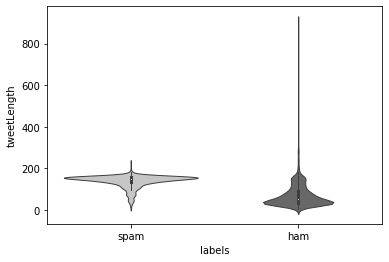

In [6]:
######### Violin Plot  https://www.python-graph-gallery.com/39-hidden-data-under-boxplot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
##import pandas as pd
 
# Dataset:
##a = pd.DataFrame({ 'group' : np.repeat('A',500), 'value': np.random.normal(10, 5, 500) })
##b = pd.DataFrame({ 'group' : np.repeat('B',500), 'value': np.random.normal(13, 1.2, 500) })
##c = pd.DataFrame({ 'group' : np.repeat('B',500), 'value': np.random.normal(18, 1.2, 500) })
##d = pd.DataFrame({ 'group' : np.repeat('C',20), 'value': np.random.normal(25, 4, 20) })
##e = pd.DataFrame({ 'group' : np.repeat('D',100), 'value': np.random.uniform(12, size=100) })
##df=a.append(b).append(c).append(d).append(e)

# plot violin chart
# sns.violinplot( x='group', y='value', data=df)
sns.violinplot( x='labels', y='tweetLength', data=df,
               order=[pos_label, neg_label],
               palette="Greys",  ### Blues, Set1, Set2, Accent, Set2_r, Spectral, gist_heat, gist_rainbow_r, Greys
               linewidth=1,
               orient="v")
plt.savefig("tweetLenBoxP.pdf",dpi=500 )

# add title
## plt.title("Violin plot", loc="left")

# show the graph
#plt.show()



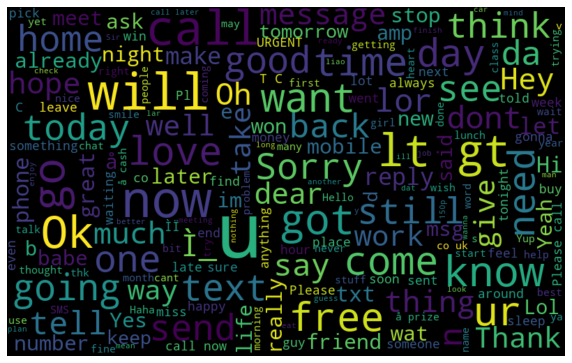

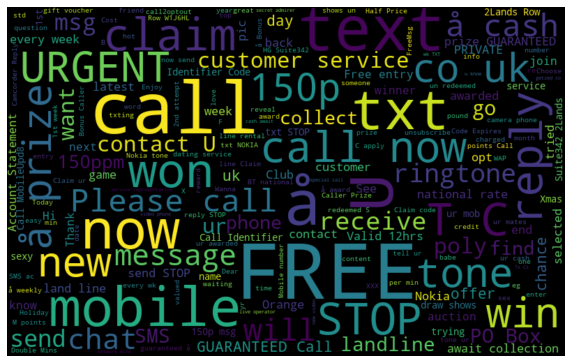

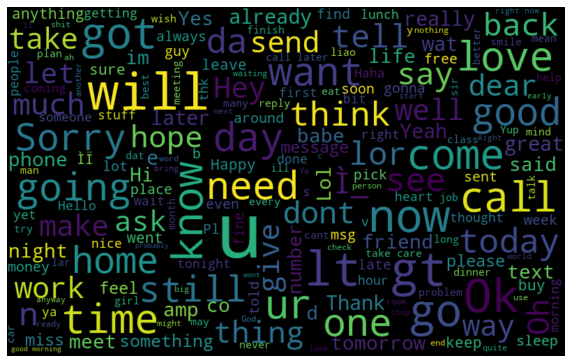

In [7]:
### Wordclouds
# WordCloud
all_words = ' '.join([text for text in X])
all_pos_words = ' '.join([text for text in df[df['labels'] == pos_label]['text']]) 
all_neg_words = ' '.join([text for text in df[df['labels'] == neg_label]['text']]) 
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
wordcloud_pos = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_pos_words) 
wordcloud_neg = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_neg_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud_pos, interpolation="bilinear") 
plt.axis('off') 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud_neg, interpolation="bilinear") 
plt.axis('off') 
plt.show()


In [8]:
### (Step 3)
### Setup tokenizer parameters

import nltk
import re
def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]\@*", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    # Removing short words
    #for word in list(words):
    #  if len(word) <= 3:
    #    words.remove(word)
    return words


In [9]:
### (Step 4)
##### Text Feature Extraction [TF-iDF]#####
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(Y)

tfidf_vect = TfidfVectorizer(encoding='ISO-8859-1', tokenizer=Tokenizer, max_features=None)
#tfidf_vect = TfidfVectorizer(encoding='ISO-8859-1', tokenizer=Tokenizer, stop_words='english', max_features=None)
X_tfidf =  tfidf_vect.fit_transform(X)

def return_vocab(tfidf_vector):
    vocab ={ v:k for k,v in tfidf_vector.vocabulary_.items()}
    return vocab

def return_weights(vocab, original_vocab, vector, vector_index, top_n):
    zipped = dict(zip(vector[vector_index].indices, vector[vector_index].data))
    
    # Let's transform that zipped dict into a series
    zipped_series = pd.Series({vocab[i]:zipped[i] for i in vector[vector_index].indices})
    #print("zipped_series:\n",zipped_series)
    # Let's sort the series to pull out the top n weighted words
    zipped_index = zipped_series.sort_values(ascending=False)[:top_n].index
    #print("zipped_index:\n", zipped_index)
    return [original_vocab[i] for i in zipped_index]

vocab = return_vocab(tfidf_vect)

In [10]:
X_tfidf.shape[1]  # number of features 

7419

In [ ]:
### Print all features and their TFiDF value.
idf = tfidf_vect.idf_
print(dict(zip(tfidf_vect.get_feature_names(), idf)))

In [ ]:
### To return selected words after optimization and selection steps.... (Optional)
#### Get Words, Indices, Value and Save Selected Words
recordIndex = 1
print(X_tfidf[recordIndex].indices)
print(X[recordIndex])
print(X_tfidf[recordIndex].data)
#print(X_tfidf[recordIndex,2828])
#for i in (X_tfidf[recordIndex].indices):
#  print(vocab[i],":",X_tfidf[recordIndex,i])
for i in (X_tfidf[recordIndex].indices):
  print(vocab[i], end=", ")
print()
print(Y[recordIndex])

def get_SelectedFeaturesWords(FeaturesIndices):
  words=[]
  for i in FeaturesIndices:
    words.append(vocab[i])
  return words
selectedWords = get_SelectedFeaturesWords(gen_BestSelectedFeaturesIndices)

print("best selected words: ", selectedWords)

SelWordsfileName = classifierName + "_" + FileID + "SelWords" +".csv"
np.savetxt(SelWordsfileName, selectedWords, delimiter=",", fmt='%s')

In [15]:
### (Step 5)


### randomize features over parents. used to generate reduced features (random feature selecton)
import random
random.seed(RSeed)

numberOfDatasetFeatures = X_tfidf.shape[1] # total number of features in the dataset


# Define the number of 1'(i.e. K )s in a randomly distributed array of size N
def rand_bin_array(K, N):
    arr = np.zeros(N, dtype=int)
    arr[:K]  = 1
    np.random.shuffle(arr)
    return arr   

def get_RandomOnesArray(TotalnumberOfDatasetFeatures):
  NumberofSelFeatures = random.randint(1,TotalnumberOfDatasetFeatures)
  #NumberofSelFeatures = int(np.ceil(0.5 * TotalnumberOfDatasetFeatures)) #Percentage of features number to be selected
  BinaryFeaturesList = rand_bin_array(NumberofSelFeatures,TotalnumberOfDatasetFeatures)
  return NumberofSelFeatures, BinaryFeaturesList 

def select_FeaturesIndices(TotalnumberOfDatasetFeatures, NumberofFeatures2Select):
  BinaryFeaturesList = rand_bin_array(NumberofFeatures2Select,TotalnumberOfDatasetFeatures)
  SelectedFeaturesIndices = np.where(BinaryFeaturesList == 1)[0]
  return SelectedFeaturesIndices


def get_ValuesDropDuplicates(CompleteList):
  return list(dict.fromkeys(CompleteList))
  

In [18]:
### (Step 6)  The Modified GA
### [V2] XGBoost Parameter Tuning and Feature Selection using (Genetic Alg...)
### Based on https://github.com/mjain72/Hyperparameter-tuning-in-XGBoost-using-genetic-algorithm/blob/master/geneticXGboost.py

import numpy as np
import pandas as pd
import random
import xgboost as xgb
import matplotlib.pyplot as plt

random.seed(RSeed)
np.random.seed(RSeed)


def initilialize_poplulation(numberOfParents):
    numberOfDatasetFeatures = X_tfidf.shape[1] # total number of features in the dataset

    learningRate = np.empty([numberOfParents, 1])
    nEstimators = np.empty([numberOfParents, 1], dtype = np.uint8)
    maxDepth = np.empty([numberOfParents, 1], dtype = np.uint8)
    minChildWeight = np.empty([numberOfParents, 1])
    gammaValue = np.empty([numberOfParents, 1])
    subSample = np.empty([numberOfParents, 1])
    colSampleByTree =  np.empty([numberOfParents, 1])

    features = np.empty([numberOfParents,NumFeat2Select], dtype=int)

    for i in range(numberOfParents):
        #print("Parent ", i, end =" ")
        learningRate[i] = round(random.uniform(0.01, 1), 2)
        nEstimators[i] = random.randrange(10, 1500, step = 25)
        maxDepth[i] = int(random.randrange(1, 10, step= 1))
        minChildWeight[i] = round(random.uniform(0.01, 10.0), 2)
        gammaValue[i] = round(random.uniform(0.01, 10.0), 2)
        subSample[i] = round(random.uniform(0.01, 1.0), 2)
        colSampleByTree[i] = round(random.uniform(0.01, 1.0), 2)
        SelFeaturesIndList = select_FeaturesIndices(numberOfDatasetFeatures, NumFeat2Select)
        features[i] = SelFeaturesIndList
        
        # Testing and Printing Outputs
        #print(" # Features ", NumberofSelectedFeatures, " | ", BinaryFeaturesList, end =" ")
        #print(" # Features", SelFeaturesIndList)
        #features[i] = random.sample(range(numberOfDatasetFeatures), feat_size) #random samples covering all the feature list
        # numOfFeat, FeatIndices = get_SelectedFeaturesIndices(numberOfDatasetFeatures)
        # features[i] = FeatIndices
    
    print()
    population = np.concatenate((learningRate, nEstimators, maxDepth, minChildWeight, gammaValue, subSample, colSampleByTree, features), axis= 1)
    population
    return population


#create fitness function that will predict F1_score 
def fitness_f1score(y_true, y_pred):
    fitness = round((f1_score(y_true, y_pred, average='weighted')), 4)
    return fitness

### Added by Nazeeh Ghatasheh
from imblearn.metrics import geometric_mean_score
def fitness_GMean_score(y_true, y_pred):
  #fitness = round( geometric_mean_score(y_true, y_pred, average='weighted', pos_label=pos_label), 4) 
  fitness = round( geometric_mean_score(y_true, y_pred, average='weighted'), 4)
  return fitness

#train the data annd find fitness score
def train_population(population):
    fScore = []
    for i in range(population.shape[0]):
        param = { 'objective':'binary:logistic',
              'learning_rate': population[i][0],
              'n_estimators': population[i][1], 
              'max_depth': int(population[i][2]), 
              'min_child_weight': population[i][3],
              'gamma': population[i][4], 
              'subsample': population[i][5],
              'colsample_bytree': population[i][6],
              'seed': RSeed}
        #get the indices of the selected features
        #SelectedFeatures = get_SelectedFeaturesIndices(population[i][7:])
        SelectedFeatures = get_ValuesDropDuplicates(population[i][7:])
        # SelectedFeatures = population[i][7:]
        # print(SelectedFeatures)
        
        dMatrixTrain = xgb.DMatrix(X_train[:,SelectedFeatures], label=y_train) #create Dmatrix
        dMatrixtest = xgb.DMatrix(X_test[:,SelectedFeatures], label=y_test)

        #print("ind", len(SelectedFeatures), SelectedFeatures)

        num_round = 100
        xgbT = xgb.train(param, dMatrixTrain, num_round)
        preds = xgbT.predict(dMatrixtest)
        preds = preds>0.5
        fScore.append(fitness_GMean_score(y_test, preds))
    return fScore


#select parents for mating
def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) #create an array to store fittest parents
    
    #find the top best performing parents
    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 #set this value to negative, in case of F1-score, so this parent is not selected again
    return selectedParents
        

#### Modified Crossover to include features and parameters
def crossover_ParamFeat_uniform(parents, childrenSize):
    
    crossoverPointIndex_par = np.arange(0, np.uint8(numberOfXGBParameters), 1, dtype= np.uint8) #get all the indices of the parameters
    crossoverPointIndex_feat = np.arange(numberOfXGBParameters, np.uint16(childrenSize[1]), 1, dtype= np.uint16) #get all the indices of the features

    #xgb Parameters Crossover Indices
    crossoverPointIndex1 = get_ValuesDropDuplicates(np.random.randint(0, np.uint8(numberOfXGBParameters), np.uint8(numberOfXGBParameters/2)) ) # select about half  of the indices randomly
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex_par) - set(crossoverPointIndex1))) #select leftover indices

    #Features Crossover Indices
    crossoverPointIndex1_feat = get_ValuesDropDuplicates(np.random.randint(numberOfXGBParameters, np.uint16(childrenSize[1]), np.uint16(NumFeat2Select/2)) ) # select half  of the indices randomly
    crossoverPointIndex2_feat = np.array(list(set(crossoverPointIndex_feat) - set(crossoverPointIndex1_feat))) #select leftover indices


    #print("Crossover Par:", crossoverPointIndex_par, crossoverPointIndex1, crossoverPointIndex2, childrenSize)
    #print("Crossover Feat:", crossoverPointIndex_feat, crossoverPointIndex1_feat, crossoverPointIndex2_feat, childrenSize)
    #print("Children indices;", crossoverPointIndex1, crossoverPointIndex2, crossoverPointIndex1_feat, crossoverPointIndex2_feat)


    children = np.empty(childrenSize, dtype=float)
    

    for i in range(childrenSize[0]):
        
        #find parent 1 index 
        parent1_index = i%parents.shape[0]
        #find parent 2 index
        parent2_index = (i+1)%parents.shape[0]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]

        #insert features based on random selected indices in parent 1
        children[i, crossoverPointIndex1_feat] = parents[parent1_index, crossoverPointIndex1_feat]
        #insert features based on random selected indices in parent 1
        children[i, crossoverPointIndex2_feat] = parents[parent2_index, crossoverPointIndex2_feat]
    return children


    

def mutation(crossover, numberOfXGBParameters, NumFeat2Select):
    #Define minimum and maximum values allowed for each parameter

    minMaxValue = np.zeros((numberOfXGBParameters, 2))
    
    ### Booster Parameters
    minMaxValue[0:] = [0.01, 2.0] #min/max learning rate
    minMaxValue[1, :] = [10, 500] #min/max n_estimator
    minMaxValue[2, :] = [3, 10] #min/max depth
    minMaxValue[3, :] = [0, 10.0] #min/max child_weight
    minMaxValue[4, :] = [0.01, 10.0] #min/max gamma
    minMaxValue[5, :] = [0.5, 1.0] #min/maxsubsample
    minMaxValue[6, :] = [0.5, 1.0] #min/maxcolsample_bytree
 
    # (Parameters) Mutation changes a single gene in each offspring randomly.
    mutationValue = 0
    parameterSelect = np.random.randint(0, numberOfXGBParameters, 1)
    #print(parameterSelect)
    #print("mutated parameter gene @", parameterSelect)
    if parameterSelect == 0: #learning_rate
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if parameterSelect == 1: #n_estimators
        mutationValue = np.random.randint(-200, 200, 1)
    if parameterSelect == 2: #max_depth
        mutationValue = np.random.randint(-5, 5, 1)
    if parameterSelect == 3: #min_child_weight
        mutationValue = round(np.random.uniform(5, 5), 2)
    if parameterSelect == 4: #gamma
        mutationValue = round(np.random.uniform(-2, 2), 2)
    if parameterSelect == 5: #subsample
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if parameterSelect == 6: #colsample
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
   
    # (Features) Mutation changes a single gene in each offspring randomly.
    mutationValue_feat = 0
    parameterSelect_feat = np.random.randint(numberOfXGBParameters, NumFeat2Select, 1) # select feature index randomly to be mutated
    # print("mutated feature gene @", parameterSelect_feat)

  
    #indtroduce mutation by changing one parameter, and set to max or min if it goes out of range
    for idx in range(crossover.shape[0]):
        crossover[idx, parameterSelect] = crossover[idx, parameterSelect] + mutationValue
        if(crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]
        if(crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]

        #Mutate features by replacing a gene with a random dataset feature. Such that the new feature is not already found in the current chromosome
        crossover[idx, parameterSelect_feat]= random.choice([x for x in range(numberOfDatasetFeatures) if x not in crossover[idx, numberOfXGBParameters:]])
        #print(crossover[idx])
        #print("mutated features gene @", parameterSelect_feat, " to be: ", crossover[idx, parameterSelect_feat])
    return crossover


'''
This function will allow us to genrate the heatmap for various parameters and fitness to visualize 
how each parameter and fitness changes with each generation
'''
def plot_parameters(numberOfGenerations, numberOfParents, parameter, parameterName):
    #inspired from https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
    generationList = ["Gen {}".format(i) for i in range(numberOfGenerations+1)]
    populationList = ["Parent {}".format(i) for i in range(numberOfParents)]
    
    fig, ax = plt.subplots()
    im = ax.imshow(parameter, cmap=plt.get_cmap('YlOrBr'))
    # show ticks
    ax.set_xticks(np.arange(len(populationList)))
    ax.set_yticks(np.arange(len(generationList)))
    
    # show labels
    ax.set_xticklabels(populationList)
    ax.set_yticklabels(generationList)
    
    # set ticks at 45 degrees and rotate around anchor
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    
    # insert the value of the parameter in each cell
    for i in range(len(generationList)):
        for j in range(len(populationList)):
            text = ax.text(j, i, parameter[i, j],
                           ha="center", va="center", color="k")
    
    ax.set_title("Change in the value of " + parameterName)
    fig.tight_layout()
    plt.show()


##############################################################################################
'''
---------------------------------------------------------------------------------------------
            MAIN CODE Below
---------------------------------------------------------------------------------------------
'''
############### Main Code for Parameters Optimization and Feature Selection using the modified GA #########

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size = 0.3, random_state = 97)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
numberOfDatasetFeatures = X_tfidf.shape[1] # total number of features in the dataset


### GA Configuration.....
Perc2Sel = 0.01
CrossoverRatio = 0.4
NumFeat2Select = int(np.ceil(Perc2Sel * numberOfDatasetFeatures)) # Maximum number of features to select

numberOfParents = 100 #number of parents to start
# numberOfParents = int(np.ceil(2 * NumFeat2Select))
numberOfParentsMating = int(np.ceil(CrossoverRatio * numberOfParents))
numberOfXGBParameters = 7  #Number of algorithm parameters to be optimized
numberOfParameters = numberOfXGBParameters + NumFeat2Select # total number of parameters to be optimized and max number of  features to be selected
numberOfGenerations = 10 #number of genrations that will be created



ExpID = "F" + str(int(Perc2Sel*100)) + "-P" + str(numberOfParents) + "-C" + str(numberOfParentsMating) + "-G" + str(numberOfGenerations)
print("ExpID:", ExpID, " NumFeat2Select:", NumFeat2Select)

GAHyperParameterTuningConf= pd.DataFrame({"pos_label":[pos_label],
                                          "FitnessFunction":["GMean"],
                   "numberOfParentstostart":[numberOfParents],
                   "numberOfParentsMating":[numberOfParentsMating],
                   "numberOfGenerations":[numberOfGenerations],
                   "numberOfXGBParameters":[numberOfXGBParameters],
                   "NumFeat2Select":[NumFeat2Select],
                   })

#define the population size
populationSize = (numberOfParents, numberOfParameters)

#initialize the population with randomly generated parameters
population = initilialize_poplulation(numberOfParents)

#define an array to store the fitness  hitory
fitnessHistory = np.empty([numberOfGenerations+1, numberOfParents])

#define an array to store the value of each parameter for each parent and generation
populationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters])

#insert the value of initial parameters to history
populationHistory[0:numberOfParents, :] = population

for generation in range(numberOfGenerations):
    print("<<<<< This is generation number %s " % (generation) ," >>>>>")
    
    #train the dataset and obtain fitness
    fitnessValue = train_population(population=population)

    fitnessHistory[generation, :] = fitnessValue
    
    #best score in the current iteration
    print('Best Fitness score in the this iteration = {}'.format(np.max(fitnessHistory[generation, :])))

    #survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected
    parents = new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfParentsMating)
    
    #mate these parents to create children having parameters from these parents
    children = crossover_ParamFeat_uniform(parents=parents, childrenSize=(populationSize[0] - parents.shape[0], numberOfParameters))

    #add mutation to create genetic diversity
    ##children_mutated = mutation(children, numberOfParameters)
    children_mutated = mutation(children, numberOfXGBParameters, NumFeat2Select)

    
    '''
    We will create new population, which will contain parents that where selected previously based on the
    fitness score and rest of them  will be children
    '''
    population[0:parents.shape[0], :] = parents #fittest parents
    population[parents.shape[0]:, :] = children_mutated #children
    
    populationHistory[(generation+1)*numberOfParents : (generation+1)*numberOfParents+ numberOfParents , :] = population #store parent information
    

#Best solution from the final iteration
print("<<<<< Calculating fitnees of the last generation >>>>>")
#fitness = train_population(population=population, dMatrixTrain=xgDMatrix, dMatrixtest=xgbDMatrixTest, y_test=y_test)
fitness = train_population(population=population)
fitnessHistory[generation+1, :] = fitness
print('Best Fitness score of the last generation = {}'.format(np.max(fitnessHistory[generation+1, :])))

#index of the best solution
bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]

# to store best fitness in each generation.
gen_BestFitnessHistory = []
for generation in range(numberOfGenerations+1):
  max = np.max(fitnessHistory[generation, :])
  gen_BestFitnessHistory.append(max)
print(gen_BestFitnessHistory)

gen_params = {}
gen_params['objective'] = 'binary:logistic'
gen_params['learning_rate'] = population[bestFitnessIndex][0]
gen_params['n_estimators'] = int(population[bestFitnessIndex][1])
gen_params['max_depth'] = int(population[bestFitnessIndex][2])
gen_params['min_child_weight'] = population[bestFitnessIndex][3]
gen_params['gamma'] = population[bestFitnessIndex][4]
gen_params['subsample'] = population[bestFitnessIndex][5]
gen_params['colsample_bytree'] = population[bestFitnessIndex][6]
gen_params['seed'] = RSeed


#gen_BestSelectedFeaturesIndices = get_SelectedFeaturesIndices(population[bestFitnessIndex][7:])
gen_BestSelectedFeaturesIndices = get_ValuesDropDuplicates(population[bestFitnessIndex][7:])
#(gen_BestSelectedFeaturesIndices == 1).sum()



####  Reporting and Logs

#Best fitness
print("Best fitness =", fitness[bestFitnessIndex])
#print("Number of Selected Fetures =", gen_BestSelectedFeaturesIndices.size)
print("Number of Selected Fetures =", len(gen_BestSelectedFeaturesIndices))

#Best parameters
print("Best parameters are:")
#print('learning_rate', population[bestFitnessIndex][0])
#print('n_estimators', population[bestFitnessIndex][1])
#print('max_depth', int(population[bestFitnessIndex][2])) 
#print('min_child_weight', population[bestFitnessIndex][3])
#print('gamma', population[bestFitnessIndex][4])
#print('subsample', population[bestFitnessIndex][5])
#print('colsample_bytree', population[bestFitnessIndex][6])
print(gen_params)

#visualize the change in fitness of the various generations and parents
#plot_parameters(numberOfGenerations, numberOfParents, fitnessHistory, "fitness (F1-score)")

#Look at individual parameters change with generation
#Create array for each parameter history (Genration x Parents)

learnigRateHistory = populationHistory[:, 0].reshape([numberOfGenerations+1, numberOfParents])
nEstimatorHistory = populationHistory[:, 1].reshape([numberOfGenerations+1, numberOfParents])
maxdepthHistory = populationHistory[:, 2].reshape([numberOfGenerations+1, numberOfParents])
minChildWeightHistory = populationHistory[:, 3].reshape([numberOfGenerations+1, numberOfParents])
gammaHistory = populationHistory[:, 4].reshape([numberOfGenerations+1, numberOfParents])
subsampleHistory = populationHistory[:, 5].reshape([numberOfGenerations+1, numberOfParents])
colsampleByTreeHistory = populationHistory[:, 6].reshape([numberOfGenerations+1, numberOfParents])

#featCountHistory = np.empty([populationHistory.shape[0], 1])
#for p in range(populationHistory.shape[0]):
#  featCountHistory[p] = (populationHistory[p, 7:] == 1).sum()
#SelectedFeaturesCountHistory = featCountHistory[:, :].reshape([numberOfGenerations+1, numberOfParents])


### Save to files
CurrentBestSolSummary = pd.DataFrame({
    "ExpID":[ExpID],
    "BestFitness":[fitness[bestFitnessIndex]],
    "FitnessFunction":["GMean"],
    "numberOfParentstostart":[numberOfParents],
    "numberOfParentsMating":[numberOfParentsMating],
    "numberOfGenerations":[numberOfGenerations],
    "numberOfXGBParameters":[numberOfXGBParameters],
    "Perc2Sel":[Perc2Sel],
    "NumFeat2Select":[NumFeat2Select],
    "NumOfSelectedFeatures":[len(gen_BestSelectedFeaturesIndices)],
    "pos_label":[pos_label],
    "objective":[gen_params['objective']],
    "learning_rate":[gen_params['learning_rate']],
    "n_estimators":[gen_params['n_estimators']],
    "max_depth":[gen_params['max_depth']],
    "min_child_weight":[gen_params['min_child_weight']],
    "gamma":[gen_params['gamma']],
    "subsample":[gen_params['subsample']],
    "colsample_bytree":[gen_params['colsample_bytree']],
    "seed":[gen_params['seed']],
    "gen_BestSelectedFeaturesIndices":[gen_BestSelectedFeaturesIndices],
    "gen_BestFitnessHistory":[gen_BestFitnessHistory],

    })
AllBestSolSummary = AllBestSolSummary.append(CurrentBestSolSummary, ignore_index=True)
AllBestSolSummaryfileName = classifierName + "_" + FileID + "_AllBestSolSummary" + ".csv"
FileLocation = FolderPath + AllBestSolSummaryfileName
AllBestSolSummary.to_csv(FileLocation)
#print(CurrentBestSolSummary)
#print(AllBestSolSummary)


#### Extra Reporting
#populationHistoryfileName = ExpID + "_" + classifierName + "_" + FileID + "_PopulationHistory" + ".csv"
#np.savetxt(populationHistoryfileName, populationHistory[:,0:7], delimiter=",") #Save Classifier Parameters
#fitnessHistoryfileName = ExpID + "_" + classifierName + "_" + FileID + "_FitnessHistory" + ".csv"
#np.savetxt(fitnessHistoryfileName, fitnessHistory, delimiter=",")
#SelectedFeaturesIndicesHistoryfileName = ExpID + "_" + classifierName + "_" + FileID + "_SelectedFeaturesIndices" + ".csv"
#np.savetxt(SelectedFeaturesIndicesHistoryfileName, populationHistory[:,7:], delimiter=",")
#SelectedBinaryFeaturesHistoryfileName = classifierName + "_" + FileID + "_SelectedBinaryFeatures" + ".csv"
#np.savetxt(SelectedBinaryFeaturesHistoryfileName, populationHistory[:,7:], delimiter=",")

#generate heatmap for each parameter

#plot_parameters(numberOfGenerations, numberOfParents, learnigRateHistory, "learning rate")
#plot_parameters(numberOfGenerations, numberOfParents, nEstimatorHistory, "n_estimator")
#plot_parameters(numberOfGenerations, numberOfParents, maxdepthHistory, "maximum depth")
#plot_parameters(numberOfGenerations, numberOfParents, minChildWeightHistory, "minimum child weight")
#plot_parameters(numberOfGenerations, numberOfParents, gammaHistory, "gamma")
#plot_parameters(numberOfGenerations, numberOfParents, subsampleHistory, "subsample")
#plot_parameters(numberOfGenerations, numberOfParents, colsampleByTreeHistory, "col sample by history")
#plot_parameters(numberOfGenerations, numberOfParents, SelectedFeaturesCountHistory, "Number of Selected Features")


ExpID: F1-P100-C40-G10  NumFeat2Select: 75

<<<<< This is generation number 0   >>>>>
Best Fitness score in the this iteration = 0.6448
<<<<< This is generation number 1   >>>>>
Best Fitness score in the this iteration = 0.6448
<<<<< This is generation number 2   >>>>>
Best Fitness score in the this iteration = 0.6819
<<<<< This is generation number 3   >>>>>
Best Fitness score in the this iteration = 0.7232
<<<<< This is generation number 4   >>>>>
Best Fitness score in the this iteration = 0.7523
<<<<< This is generation number 5   >>>>>
Best Fitness score in the this iteration = 0.7932
<<<<< This is generation number 6   >>>>>
Best Fitness score in the this iteration = 0.7932
<<<<< This is generation number 7   >>>>>
Best Fitness score in the this iteration = 0.7932
<<<<< This is generation number 8   >>>>>
Best Fitness score in the this iteration = 0.7979
<<<<< This is generation number 9   >>>>>
Best Fitness score in the this iteration = 0.802
<<<<< Calculating fitnees of the last

In [23]:
### (Step 7)

#Calssifier Test No 2. #### XGBoost Runs and CV Setup + Using GA Selected Features (Main Code) ########

### TiPS https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


# Building a pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

###### Tuning Parameters After GA Optimizatoin Step >>>>> uncomment the following line
TuningParameters = GAHyperParameterTuningConf  # Get GA Hyperparameter tuning configuration

######### Fill in GA Hyperparameter tuning configuration manually ##################################
#TuningParameters = pd.DataFrame({"pos_label":[pos_label], 
#                    "numberOfParentstostart":[00],
#                    "numberOfParentsMating":[00],
#                    "numberOfParameters":[00],
#                    "numberOfGenerations":[00],
#                    })


### To load saved configurations uncomment the following
# saved_conf_ind = 0
# TuningParameters = get_GAHyperParameterTuningConf(saved_conf_ind)
# gen_params = get_gen_Params(saved_conf_ind)
# features_list_txt = data["gen_BestSelectedFeaturesIndices"]
# features_list= convert_txt2list(features_list_txt, True, False)
# gen_BestSelectedFeaturesIndices = features_list[saved_conf_ind]


# gen_params = [colsample_bytree=0.69, gamma=0.33, learning_rate=0.31,
#               max_depth=10, min_child_weight=0.15, n_estimators=47, seed=723.0,
#               subsample=1.0]

 # Parameters used for optimization e.g. GA pop 100 iterations 20

######### Fill in XGBOOST tuned parameters manually ##################################
# XGBParameters = pd.DataFrame({"Best_fitness":[0.0], 
#                     "learning_rate":[0.41],
#                     "n_estimators":[100],
#                     "max_depth":[5],
#                     "min_child_weight":[0.15],
#                     "gamma":[1.06],
#                     "subsample":[0.99],
#                     "colsample_bytree":[0.55]
#                     })

#XGBParameters = GBestParameters  # Get XGBOOST parameters found by GA Optimization
#XGBParameters = gen_params



pd.set_option('display.max_columns', None)
print("Gen. TuningParameters:\n",TuningParameters)
#print("XGBParameters:\n", XGBParameters)
print("\nClassification POS Label: ", pos_label, ", NEG Label: ", neg_label, "\n")
print(gen_params, "\n")
classifier = XGBClassifier(**gen_params)

#classifier = Pipeline([
    # ('vect', TfidfVectorizer(encoding='ISO-8859-1', tokenizer=Tokenizer, max_features=100)),
    #'vect', CountVectorizer(encoding='ISO-8859-1', tokenizer=Tokenizer)),
    #('tfidf', TfidfTransformer()),
#    ('featSelection', SelectKBest(chi2, k=10)),
#    ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
#    ('clf', XGBClassifier(
 #       learning_rate= float(XGBParameters['learning_rate']),
 #       n_estimators= int(XGBParameters['n_estimators']),
 #       max_depth= int(XGBParameters['max_depth']),
 #       min_child_weight= float(XGBParameters['min_child_weight']),
 #       gamma= float(XGBParameters['gamma']),
 #       subsample= float(XGBParameters['subsample']),
 #       colsample_bytree= float(XGBParameters['colsample_bytree'])
#        )),
#])



###### Cross Validation Code by Nazeeh
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, cross_val_score
from sklearn.metrics import make_scorer, classification_report, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, auc
import math
#from sklearn.metrics import plot_roc_curve
#from sklearn import metrics

number_of_folds = 10
skf = StratifiedKFold(n_splits=number_of_folds, shuffle=True)

# Variables for average classification report
originalclass = []
predictedclass = []


def classification_report_nz(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
#    print (classification_report(y_true, y_pred)) # print classification report
    print ('.', end=" ")
    return accuracy_score(y_true, y_pred) # return accuracy score

# Confusion Matrix entries for the scorer (a wrapper to return a single metric)
def tn(y_true, y_pred): 
  return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred):
  return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred):
  return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred):
  return confusion_matrix(y_true, y_pred)[1, 1]

# define AUC scoring function 
def custom_auc(y_true, y_pred):
  fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=pos_label)
  #print('fpr: ',fpr,'\ntpr: ',tpr, '\nthreshold: ',threshold,'\n')
  return auc(fpr, tpr)



### Performance measures setup
scoring = {
           'tp': make_scorer(tp),
           'tn': make_scorer(tn),
           'fp': make_scorer(fp),
           'fn': make_scorer(fn),
           'prec': make_scorer(precision_score, pos_label=pos_label),
           'rec': make_scorer(recall_score, pos_label=pos_label),
           'f1': make_scorer(f1_score, pos_label=pos_label),
           #'prec_macro': 'precision_macro',
           #'rec_macro': make_scorer(recall_score, average='macro'),
           'accuracy':'accuracy',
           'roc_auc':'roc_auc',
           'my_auc': make_scorer(custom_auc, greater_is_better=True, needs_proba=True),
           'classification_report': make_scorer(classification_report_nz)
           }

number_of_runs = 50 ### How many times the run will be repeated
run_scores=[]   ### Store the scores of all runs 

### Store the scores of all runs the to CSV
df_AllTestRUNResultsLOG = pd.DataFrame({"ExpID":[],
                                   "classifier":[],
                                   "tp":[],
                                   "tn":[],
                                   "fp":[],
                                   "fn":[],
                                   "Run_Total_Accuracy":[],
                                   "runGMeans":[],
                                   "myAUC":[],                                   
                                   "TPR":[],
                                   "TNR":[],
                                   "PPV":[],
                                   "FPR":[],
                                   "F1s":[],
                                   "NPV":[]
                    })

  

for r in range(1,number_of_runs+1):
  print( ' _________________________\n',
  '| Run Number ', r, '/', number_of_runs, ':',
  '\n ^^^^^^^^^^^^^^^^^^^^^^^^^')
  originalclass = [] #reset
  predictedclass = [] #reset
  

  scores = cross_validate(classifier, X_tfidf[:,gen_BestSelectedFeaturesIndices], Y, scoring=scoring,
                         cv=skf , return_train_score=False)
  


#### https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py
## https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 

  

  #### REPORTING ######
  
  ## Get Confusion Matrix entries
  print("\n------ Confusion Matrix, RUN: (",r,") --------\n" )
  tp= scores['test_tp']
  tn= scores['test_tn']
  fp= scores['test_fp']
  fn= scores['test_fn']
  myAUC = scores['test_my_auc']
  TPR = tp / (tp+fn) #Recall, Sensitivity
  TNR = tn / (tn+fp)  #Specificity (SPC), Selectivity
  Run_Total_Accuracy = (tp+tn)/(tp+tn+fp+fn)
  PPV = tp / (tp+fp) #Precision
  FPR = fp / (fp+tn) #Fall-out, probability of false alarm
  F1s= 2 * ( (TPR * PPV) / (TPR + PPV) )
  NPV = tn / (tn+fn)

  runGMeans=[]
  for x in range(len(TPR)):
    runGMeans.append(math.sqrt(TPR[x]*TNR[x]))

  print("Run ",r, "TPs:",tp)
  print("Run ",r, "TNs:",tn)
  print("Run ",r, "FPs:",fp)
  print("Run ",r, "FNs:",fn)
  print("\n------ Selected Measures, RUN: (",r,") --------\n" )
  print("Run ",r, "Run Total Accuracy:", Run_Total_Accuracy )
  print("Run ",r, "TPRs:",TPR)
  print("Run ",r, "TNRs:",TNR)
  print("Run ",r, "GMEANs:", runGMeans )
  print("Run ",r, "AUC POS Class:",myAUC)
  print("Run ",r, "PPV:",PPV)
  print("Run ",r, "FPR:",FPR)
  print("Run ",r, "F1s:",F1s)
  print("Run ",r, "NPV:",NPV,'\n')


  df_TestRUNResults = pd.DataFrame({"ExpID":[r for _ in range(number_of_folds)],
                                   "classifier":classifierName,
                                   "tp":tp,
                                   "tn":tn,
                                   "fp":fp,
                                   "fn":fn,
                                   "Run_Total_Accuracy":Run_Total_Accuracy,
                                   "runGMeans":runGMeans,
                                   "myAUC":myAUC,                                   
                                   "TPR":TPR,
                                   "TNR":TNR,
                                    "PPV":PPV,
                                    "FPR":FPR,
                                    "F1s":F1s,
                                    "NPV":NPV
                                    })
  
  print(df_TestRUNResults.describe())
  df_AllTestRUNResultsLOG = df_AllTestRUNResultsLOG.append(df_TestRUNResults, ignore_index = True)

### Compute Total Statistics
print(df_AllTestRUNResultsLOG.describe())
print("Saving ", FolderPath + classifierName, "_",FileID," FILES" )

# Save basic metrics and descriptions into files
df_AllTestRUNResultsLOG.to_csv(FolderPath + classifierName + "_" + FileID +"_RunsLog"+".csv")
df_AllTestRUNResultsLOG.describe().to_csv(FolderPath + classifierName + "_" + FileID +"_RunsSummary"+".csv")

file1 = open(FolderPath + classifierName + "_" + FileID +"_Configurations"+".txt","w") 
file1.write("FileID:"+ FileID + "\n") 
file1.write("classifier: "+ classifierName + "\n") 
file1.write("Tuning Parameters: "+ TuningParameters.to_string() + "\n") 
file1.write("XGBoost Best Parameters: "+ str(gen_params) + "\n")
#file1.write("XGBoost Best Parameters: "+ XGBParameters.to_string() + "\n")
file1.write("Classification POS Label: "+ pos_label + ", NEG Label:" + neg_label +"\n")
file1.write("classifier Configurations: \n" + str(classifier.get_params) +"\n") 
#file1.writelines(L) 
file1.close()

print( '*****************Completed**********************')
df_AllTestRUNResultsLOG.describe()


Gen. TuningParameters:
   pos_label FitnessFunction  numberOfParentstostart  numberOfParentsMating  \
0      spam           GMean                     100                     40   

   numberOfGenerations  numberOfXGBParameters  NumFeat2Select  
0                   10                      7              75  

Classification POS Label:  spam , NEG Label:  ham 

{'objective': 'binary:logistic', 'learning_rate': 0.97, 'n_estimators': 26, 'max_depth': 3, 'min_child_weight': 0.44, 'gamma': 1.21, 'subsample': 0.58, 'colsample_bytree': 0.61, 'seed': 723} 

 _________________________
 | Run Number  1 / 50 : 
 ^^^^^^^^^^^^^^^^^^^^^^^^^
. . . . . . . . . . 
------ Confusion Matrix, RUN: ( 1 ) --------

Run  1 TPs: [40 56 50 41 48 46 40 42 45 40]
Run  1 TNs: [475 468 472 475 476 479 469 468 473 470]
Run  1 FPs: [ 8 15 11  8  7  3 13 14  9 12]
Run  1 FNs: [35 19 24 33 26 29 35 33 30 35]

------ Selected Measures, RUN: ( 1 ) --------

Run  1 Run Total Accuracy: [0.92293907 0.9390681  0.93716338 0.92

,ExpID,tp,tn,fp,fn,Run_Total_Accuracy,runGMeans,myAUC,TPR,TNR,PPV,FPR,F1s,NPV
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,25.500000,45.632000,472.406000,10.094000,29.068000,0.929717,0.772456,0.850657,0.610883,0.979080,0.821267,0.020920,0.698737,0.942109
std,14.445322,4.379834,3.554495,3.509101,4.390208,0.009652,0.037143,0.026004,0.058659,0.007273,0.052551,0.007273,0.046209,0.008228
min,1.000000,31.000000,461.000000,1.000000,16.000000,0.906643,0.644554,0.774327,0.418919,0.954451,0.676471,0.002070,0.566667,0.917625
25%,13.000000,42.000000,470.000000,7.000000,26.000000,0.922801,0.743953,0.832438,0.567568,0.973085,0.784069,0.014523,0.666667,0.935936
50%,25.500000,46.000000,473.000000,10.000000,29.000000,0.929982,0.775810,0.850871,0.613333,0.979296,0.823529,0.020704,0.703563,0.942346
75%,38.000000,48.250000,475.000000,13.000000,32.000000,0.937163,0.797466,0.868771,0.649820,0.985477,0.859649,0.026915,0.733813,0.947686
max,50.000000,58.000000,482.000000,22.000000,43.000000,0.956912,0.874249,0.932809,0.783784,0.997930,0.980392,0.045549,0.823529,0.967146
